# Time Correlation Filter Function

The Purpose of this Notebook will be to to plan and test a time correlation function that will filter sources depending on how well its opitcal and radio data lines up timewise.

The goal so far is to collect the optical and radio data for all the eta-v filtered sources (206 of them), and put them into two dataframes: fsd for FINK data and vsd for VAST data.

I've managed to construct vsd fine, but I'm having issues constructing fsd. when I run the portal request for the full list of sources, even with batching, the kernel appears to die and the notebook is reset. This happens even when the request is contained in a function I've called 'query_fink_db', which you can find in Projecttools.py. This Kernel restart error dosent happen if the ID list is sufficiently small (I tested 12 IDS with batching and it worked fine.)

In [1]:
#here are the necessary imports
import os
import sys
import gc
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from io import StringIO
from vasttools.pipeline import Pipeline
from vasttools.query import Query
import Projecttools as pro #brand new module for frequently used code!

%matplotlib inline

In [2]:
cms = pd.read_pickle('Fink_2020_sources_matched_to_VAST_all_sources.pickle')
pro.family_sort(cms)
cms.groupby('family').size().sort_values(ascending=False)

family
AGN                827
Unknown            516
Galaxy             167
Solar System        81
Radio               70
Supernova           51
Multiwavelength     39
Star                21
dtype: int64

In [3]:
#This will automatically find the base directory that needed to be specified
pipe=Pipeline()
#this way, we can also load specific runs from the VAST pipeline:
my_run=pipe.load_run('tiles_corrected')

/opt/conda/lib/python3.9/site-packages/vasttools/pipeline.py:2609: UserWarning: Measurements have been loaded with vaex.
  warnings.warn("Measurements have been loaded with vaex.")


In [4]:
#Im just putting the eta and v threshholds because the eta-v analysis takes an actual eternity to complete and I already
#have the values here:
eta_thresh=2.315552652171963
v_thresh=0.2878888414273631

In [5]:
cms_candidates = pro.eta_v_candidate_filter(cms,my_run,eta_thresh,v_thresh)
cms_candidates.groupby('family').size().sort_values(ascending=False)

There are 213 candidate sources:


family
AGN                93
Unknown            53
Solar System       30
Galaxy             15
Radio               9
Star                5
Multiwavelength     4
Supernova           4
dtype: int64

I will be testing out this function on the ETA-V filtered sources. In order for this to work, I need to have both the radio and optical data available for each source. Since the FINK broker has a limit as to how many sources can be queried at a time, I've done some "Batching:" breaking up the ID list into batches, running the portal query, and stitching the results of each batch together into a DataFrame.

In [22]:
#These IDs are selected from the curated list of interesting sources (lightcurves can be seen via powerpoint.)
Idlist=cms_candidates['objectId']

In [24]:
num_elem=len(Idlist)#length of id list
num_chunks=num_elem//30+1 #number of chunks, based on how you want to divide them up. in this case, 10 IDS per chunk
list_chunks=(np.array_split(np.arange(num_elem), num_chunks))#np.arange(num_elem) makes an ordered array, from 0 to (num_elem - 1).
                                                            #np.array_split splits said ordered array according to the number of chunks specified by num_chunks
                                                            #each chunk is an element in the array 'list_chunks'
for i in list(range(len(list_chunks))):
    list_chunks[i]=list_chunks[i].tolist()

#defining column array for cutouts
cutouts=[
'b:cutoutScience_stampData',
'b:cutoutTemplate_stampData',
'b:cutoutDifference_stampData'
]

for chunk_idx in list_chunks: #for each chunk in list_chunks
    start,end=chunk_idx[0],chunk_idx[-1]+1 #define the starting and ending indexes for the given chunk

    #this is the request made to the fink portal to pull out the info for each source
    #df_tmp=pro.query_fink_db(Idlist[start:end])
    r = requests.post(
        'https://fink-portal.org/api/v1/objects',
        json={
        'objectId': ','.join(Idlist[start:end]), #This is where the 'chunk_idx[-1] +1' comes into play. the 'end' variable when slicing the list is inclusive of the index.
        'output-format': 'json',
        'withcutouts': 'True',
        #'columns': 'i:objectId,v:firstdate,v:lastdate',
        'cols': ','.join(cutouts),
        'withupperlim': 'True' #important for lightcurve plotting
        }
    )
    df_tmp=pd.read_json(StringIO(r.content.decode()))#define a temporary dataframe that holds the queried sources from the chunk
    #saves the temporary dataframe to a folder as a .pkl file. the naming is based on which batch we're looking at
    df_tmp.to_pickle('/home/jovyan/work/Project_VAST_FINK/FINK_Batches_3/Batch_{}.pkl'.format(list_chunks.index(chunk_idx)+1))
    #clears memory from jupyter to help it not get stuck.
    gc.collect()

list_df=[] #empty array to hold fink sources.

for chunk_idx in list_chunks:
    #now, we're loading back in all the batches we saved and appending/concatonating them all back together into one dataframe: fsd
    df_tmp=pd.read_pickle('/home/jovyan/work/Project_VAST_FINK/FINK_Batches_3/Batch_{}.pkl'.format(list_chunks.index(chunk_idx)+1))
    list_df.append(df_tmp)
fsd_load=pd.concat(list_df)

ValueError: Expected object or value

In [27]:
r.content

b'<!DOCTYPE HTML PUBLIC "-//W3C//DTD HTML 3.2 Final//EN">\n<title>500 Internal Server Error</title>\n<h1>Internal Server Error</h1>\n<p>The server encountered an internal error and was unable to complete your request. Either the server is overloaded or there is an error in the application.</p>\n'

Alternatively, If you've already got fsd saved as a pickle file, load it here:

In [7]:
fsd=pd.read_pickle('FINK_Batches/FSD_No_Upperlim.pkl')

In [8]:
# this will convert the 'i:jd' column into MjD and rename the column to 'i:mjd'
fsd['i:jd']=fsd['i:jd']-2400000.5
fsd.rename(columns={"i:jd": "i:mjd"}, inplace=True)

In [9]:
#This will have 213, as some IDs are tied to duplicaes.
len(fsd['i:objectId'].unique())

213

As you can see below, the radio data is there.

In [10]:
#at the end, I turn the vaex Dataframelocal object into a pandas dataframe directly (our list of sources is not that large)
vsi=[]
for i in Idlist:
    y=cms_candidates[cms_candidates['objectId'] == i]['matched_id'].astype(int).values[0]
    vsi.append(y)
meas=my_run.measurements
vsd=meas[meas.source.isin(vsi)].to_pandas_df()

#This will convert the 'time' column in vsd into MJD. The difference between JD and MJD is 2400000.5
vsd['time']=vsd['time'].apply(pd.Timestamp.to_julian_date)-2400000.5
vsd.rename(columns={"time": "time_mjd"},inplace=True)

In [11]:
#that should have a length of 206, because, we're neglecting duplicate lines
len(vsd['source'].unique())

206

finally, for this function to work, it needs to know which Optical and Radio IDs correspond to the same source, so it can pull out the appropriate rows in fsd and vsd to compare.

In [12]:
#this takes the FINK and VAST IDs from the crossmatch catalogue and puts them into a dataframe, resetting the index.
cml=pd.DataFrame({"FINK ID": cms_candidates['objectId'], "VAST ID": cms_candidates['matched_id']}).reset_index()
#this drops the 'index' column leftover from cms_candidates
cml.drop('index', inplace=True, axis=1)
cml['VAST ID']=cml['VAST ID'].astype(int)

In [13]:
cml

,FINK ID,VAST ID
0,ZTF18acalcri,4141677
1,ZTF19aamtyjb,3925789
2,ZTF19ablxcfu,4152155
3,ZTF19abnevdi,3880532
4,ZTF19abxtqqt,3601365
...,...,...
208,ZTF20aapskkf,3952105
209,ZTF20aazjjqz,3444377
210,ZTF20abaaaul,4001263
211,ZTF20abxmrgk,3460721


Ok! Now that we have cml, fsd and vsd, we can begin to construct our time overlap function

In [22]:
#preamble
Overlap=[]
O=3
R=3
#x=True
#overlap.append(x)
ftd=pd.DataFrame({"i:objectId": fsd['i:objectId'], "i:mjd":fsd['i:mjd']})
vtd=pd.DataFrame({"source": vsd['source'], "time_mjd": vsd['time_mjd']})

In [23]:
#i represents the index of the row selelcted in cml. x and y are then the FINK and VAST IDs of that row respectively
i=3
x,y= cml.iloc[[i]]['FINK ID'][i], cml.iloc[[i]]['VAST ID'][i]
x,y

('ZTF19abnevdi', 3880532)

In [26]:
#these are all the rows in fsd that have the same FINK ID as the selected row in cml
ftd_temp=ftd[ftd['i:objectId']==x]
ftd_temp=ftd_temp.sort_values('i:mjd').reset_index()
ftd_temp.drop('index', inplace=True, axis=1)
ftd_temp.index.to_list()[-1]

31

In [ ]:
# j represents the jth index in ftd_temp. start is the start date at the jth row, end is the row O rows ahead.
j=0
start=ftd_temp.iloc[[j]]['i:mjd'][j]
end=ftd_temp.iloc[[j+O]]['i:mjd'][j+O]
print(start)
print(end)

In [ ]:
#these are all the rows in vsd that have the same VAST ID as the selected row in cml
vtd_temp=vtd[vtd['source']==y]
vtd_temp=vtd_temp.sort_values('time_mjd').reset_index()
vtd_temp.drop('index', inplace=True, axis=1)
vtd_temp

In [ ]:
#this will check which values within vtd_temp are between the start and end dates defined
overlap_temp=vtd_temp['time_mjd'].between(start,end)

#this will pull out all instances where there a radio point was between the given range and count them. If there were none, this will output a length of 0 (empty set)
len(overlap_temp[overlap_temp==True])

In [ ]:
if len(overlap_temp[overlap_temp==True]) >= R:
    Overlap.append(True)
    break

In [57]:
#preamble
Overlap = []
O = 3
R = 3
dt = 7

if O <= 1 or R <= 1:
    raise Exception('Please choose a minimum optical & radio observation overlap count greater than 1')
if dt < 0:
    raise Exception ('Please choose a dt >= 0')

#this takes the FINK and VAST IDs from the crossmatch catalogue and puts them into a dataframe, resetting the index.
cml = pd.DataFrame({"FINK ID": cms['objectId'], "VAST ID": cms['matched_id']}).reset_index()

#this drops the 'index' column leftover from cms_candidates
cml.drop('index', inplace=True, axis=1)
cml['VAST ID']=cml['VAST ID'].astype(int)

ftd = pd.DataFrame({"i:objectId": fsd['i:objectId'], "i:mjd":fsd['i:mjd']})
vtd = pd.DataFrame({"source": vsd['source'], "time_mjd": vsd['time_mjd']})

#i represents the index of the row selelcted in cml. x and y are then the FINK and VAST IDs of that row respectively
for i in cml.index.to_list():
    FINK_ID,VAST_ID = cml.iloc[[i]]['FINK ID'][i], cml.iloc[[i]]['VAST ID'][i]
    
    #these are all the rows in fsd that have the same FINK ID as the selected row in cml
    ftd_temp = ftd[ftd['i:objectId'] == FINK_ID]
    ftd_temp = ftd_temp.sort_values('i:mjd').reset_index()
    ftd_temp.drop('index', inplace=True, axis=1)
    
    #these are all the rows in vsd that have the same VAST ID as the selected row in cml
    vtd_temp = vtd[vtd['source'] == VAST_ID]
    vtd_temp = vtd_temp.sort_values('time_mjd').reset_index()
    vtd_temp.drop('index', inplace=True, axis=1)
    
    # j represents the jth index in ftd_temp. start is the start date at the jth row, end is the row O-1 steps ahead.
    for j in ftd_temp.index.to_list():
        
        #if we've reached the end of the list and the loop hasnt broken, it means we havent found any good overlap.
        if j+O-1 > ftd_temp.index.to_list()[-1]:
            Overlap.append(False)
            break
        
        start, end = ftd_temp.iloc[[j]]['i:mjd'][j], ftd_temp.iloc[[j+O-1]]['i:mjd'][j+O-1]
        #this checks which points in vtd_temp are within the range between start and end, +- dt incase an observation is slightly out of this range
        overlap_temp = vtd_temp['time_mjd'].between(start-dt,end+dt)
        
        #If the number of points wthin that range is >= R, we have good overlap!
        if len(overlap_temp[overlap_temp==True]) >= R:
            Overlap.append(True)
            break

Overlap.count(False),Overlap.count(True)

(151, 62)

Here, we have the above function compactified:

In [33]:
cml=pro.lightcurve_overlap_filter(cms_candidates,fsd,vsd,O=3,R=3)

Of the 213 Sources that have been analyzed, 62 of them have good overlap:


In [34]:
cml=cml[cml['Overlap'] == True].reset_index()
cml.drop('index', inplace=True, axis=1)

In [44]:
Idlist = cml['FINK ID'][0:9].to_list()

In [45]:
#defining column array for cutouts
cutouts=[
'b:cutoutScience_stampData',
'b:cutoutTemplate_stampData',
'b:cutoutDifference_stampData'
]

#this is the request made to the fink portal to pull out the info for each source
r = requests.post(
  'https://fink-portal.org/api/v1/objects',
  json={
    'objectId': ','.join(Idlist), 
    'output-format': 'json',
    'withcutouts': 'True',
    'cols': ','.join(cutouts),
    'withupperlim': 'True' #important for lightcurve plotting
  }
)

#reads in json file data as DataFrame. fsd stands for 'FINK source data'
fsd_subset=pd.read_json(StringIO(r.content.decode()))

ValueError: Expected object or value

KeyError: 'd:tag'

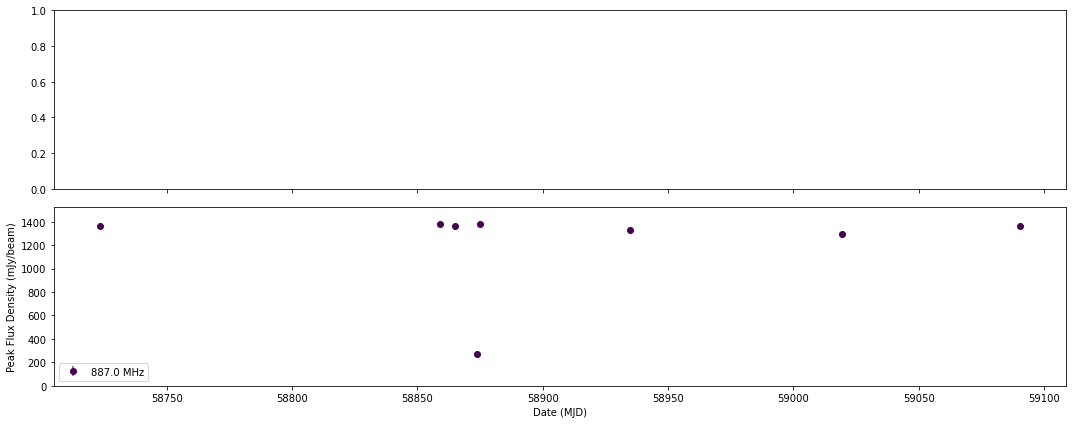

In [18]:
pro.plot_lightcurves(my_run,fsd,cms_candidates,'ZTF19aatsjqn')